## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', #origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 24000#22050
print(hparams.n_symbols,hparams.symbols_embedding_dim)

89 512


#### Load model from checkpoint

In [9]:
checkpoint_path = "ckpt/checkpoint_50000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.8/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

#### Prepare text input

In [10]:
text = ["q", "-", "i", "-", "e4", "|", "z", "-", "e", "-", "i2", "|", "^", "l", "-", "o", "-", "u4", "|", "t", "-", "u", "-", "e", "-", "i3", "|", "*", "z", "-", "ix4", "|", "ch", "-", "e", "-", "ng1", "|", "*", "h", "-", "u", "-", "a", "-", "n4", "|", "^", "m", "-", "a2", "|", "f", "-", "e", "-", "ng1", "|", "b", "-", "i", "-", "ng4", "|", "$"]*2
import json
with open("/workspace/cpfs-data/biaobei/biaobei_pingyin-dict.json") as f:
    d = json.load(f)
sequence = np.array([[d[x] for x in text]])
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

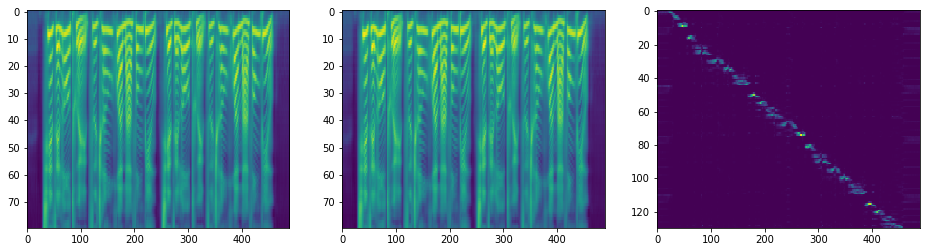

In [11]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [12]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
print(audio[0].data.cpu().numpy())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

[-1.54483660e-05 -1.13469405e-05 -2.00597169e-05 ...  1.62599499e-05
  4.13453890e-05  3.29539507e-05]


#### (Optional) Remove WaveGlow bias

In [30]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 